# Bitcoin On-Chain Market Behavior Analysis

## Overview
This project analyzes Bitcoin’s market behavior using historical price and trading volume data to identify trends, volatility patterns, and potential market signals.

The goal is to demonstrate practical data analysis skills applicable to crypto analytics and financial research roles.

## Objectives
- Analyze Bitcoin price movement over time
- Examine the relationship between trading volume and price
- Identify volatility patterns using rolling statistics
- Extract insights relevant to market behavior and risk

## Key Questions
- How does trading volume relate to price movements?
- When does volatility increase?
- Can moving averages indicate trend changes?


Let Import Libraries

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


Pull Bitcoin Market Data from CoinGecko using API

In [5]:
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    "vs_currency": "usd",
    "days": "365"
}

response = requests.get(url, params=params)
data = response.json()


In [3]:
data.keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

Convert Data to DataFrame

In [8]:
prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
prices["date"] = pd.to_datetime(prices["timestamp"], unit="ms")

prices.head()


,timestamp,price,date
0,1764136908895,87533.463853,2025-11-26 06:01:48.895
1,1764140508642,87794.924944,2025-11-26 07:01:48.642
2,1764144055607,87888.585617,2025-11-26 08:00:55.607
3,1764147665284,87388.003833,2025-11-26 09:01:05.284
4,1764151311826,86805.572910,2025-11-26 10:01:51.826


Cleaning data and save

In [9]:
prices = prices[["date", "price"]]
prices.dropna(inplace=True)

In [10]:
prices.to_csv("/content/btc_price_cleaned.csv", index=False)

First Visualization of our data

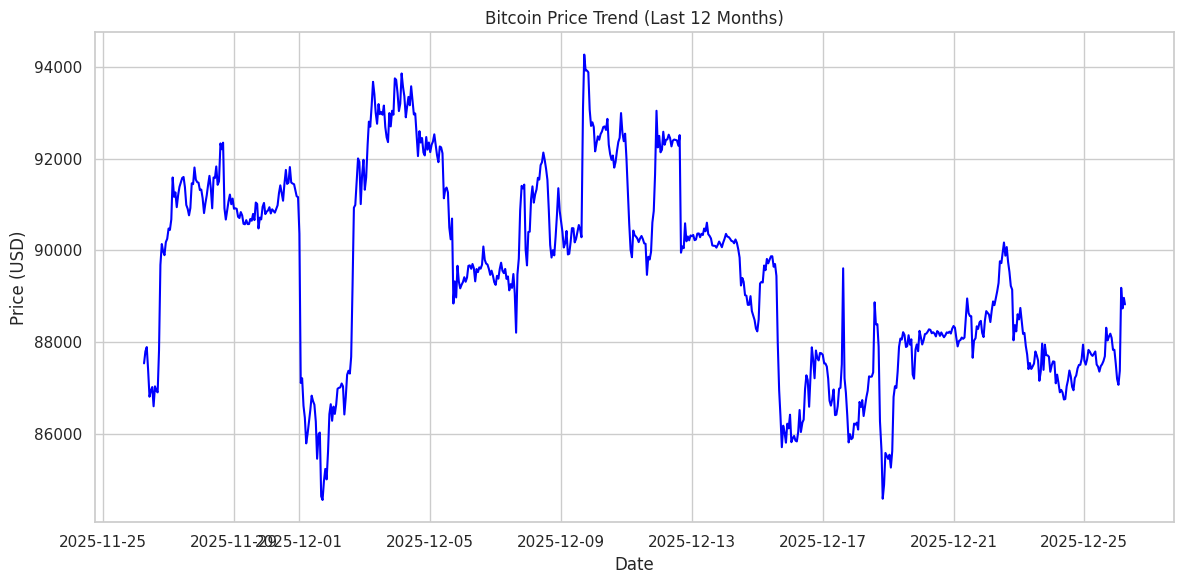

In [11]:
plt.figure(figsize=(12,6))
plt.plot(prices["date"], prices["price"], color="blue")
plt.title("Bitcoin Price Trend (Last 12 Months)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()


Fetch Transaction Volume Data (CoinGecko)

In [13]:
import requests

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "usd",
    "days": "365"
}

response = requests.get(url, params=params)
data = response.json()

volume_df = pd.DataFrame(data["total_volumes"], columns=["timestamp", "volume"])
volume_df["date"] = pd.to_datetime(volume_df["timestamp"], unit="ms")

volume_df.head()


,timestamp,volume,date
0,1735257600000,4.504934e+10,2024-12-27
1,1735344000000,4.149854e+10,2024-12-28
2,1735430400000,2.242985e+10,2024-12-29
3,1735516800000,2.406531e+10,2024-12-30
4,1735603200000,5.759516e+10,2024-12-31


Cleaning the data

In [14]:
volume_df = volume_df[["date", "volume"]]
volume_df.dropna(inplace=True)

Merge Price + Volume Data and save it.

In [24]:
prices['date'] = pd.to_datetime(prices['date']).dt.normalize()
volume_df['date'] = pd.to_datetime(volume_df['date']).dt.normalize()
merged_df = pd.merge(prices, volume_df, on="date", how="inner")
merged_df.head()

,date,price,volume
0,2025-11-26,87533.463853,6.795644e+10
1,2025-11-26,87794.924944,6.795644e+10
2,2025-11-26,87888.585617,6.795644e+10
3,2025-11-26,87388.003833,6.795644e+10
4,2025-11-26,86805.572910,6.795644e+10


In [18]:
merged_df.to_csv("/content/btc_price_volume.csv", index=False)

Second Visualize Price vs Volume

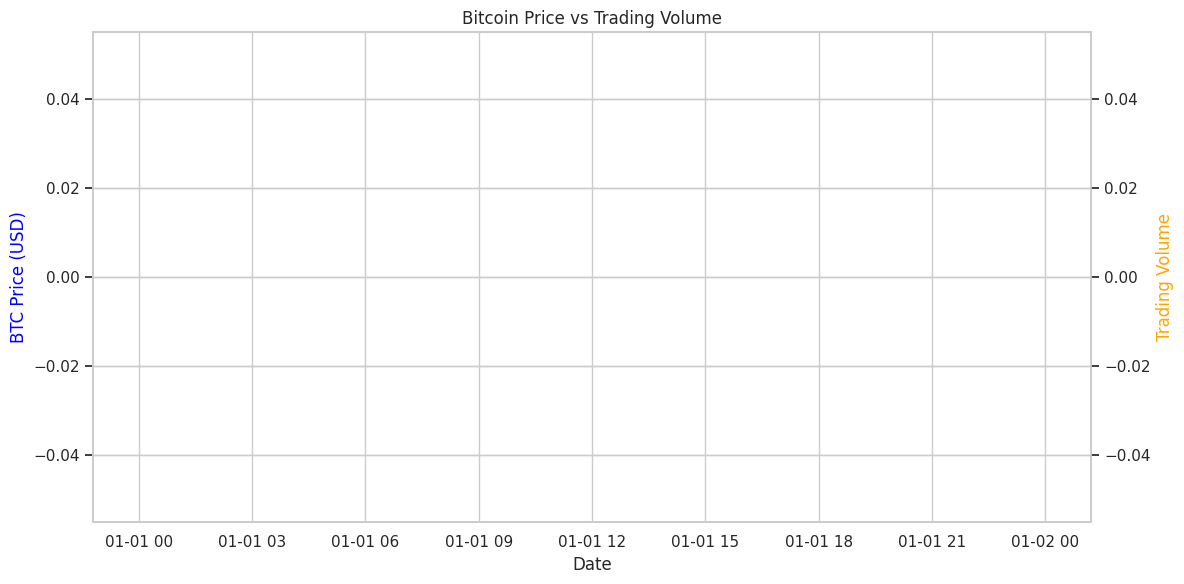

In [20]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel("Date")
ax1.set_ylabel("BTC Price (USD)", color="blue")
ax1.plot(merged_df["date"], merged_df["price"], color="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Trading Volume", color="orange")
ax2.plot(merged_df["date"], merged_df["volume"], color="orange", alpha=0.5)

plt.title("Bitcoin Price vs Trading Volume")
plt.tight_layout()
plt.show()


Correlation Analysis

In [25]:
correlation = merged_df["price"].corr(merged_df["volume"])
correlation

np.float64(0.34118520713346984)

### Insight:
The correlation between Bitcoin price and trading volume suggests that increased trading activity often coincides with significant price movements. Periods of high volume tend to align with market volatility, indicating strong investor participation during price surges or sell-offs.

In [26]:
merged_df.to_csv("/content/data_btc_price_volume.csv", index=False)

### Volatility Analysis + Moving Averages (Signal Detection)

Calculating Daily Returns

In [28]:
merged_df["daily_return"] = merged_df["price"].pct_change()
merged_df.head()

,date,price,volume,daily_return
0,2025-11-26,87533.463853,6.795644e+10,NaN
1,2025-11-26,87794.924944,6.795644e+10,0.002987
2,2025-11-26,87888.585617,6.795644e+10,0.001067
3,2025-11-26,87388.003833,6.795644e+10,-0.005696
4,2025-11-26,86805.572910,6.795644e+10,-0.006665


Calculating Rolling Volatility (7-day & 30-day)

In [31]:
merged_df["volatility_7d"] = merged_df["daily_return"].rolling(window=7).std()
merged_df["volatility_30d"] = merged_df["daily_return"].rolling(window=30).std()

Add Moving Averages (Trend Detection)

In [34]:
merged_df["MA_7"] = merged_df["price"].rolling(window=7).mean()
merged_df["MA_30"] = merged_df["price"].rolling(window=30).mean()

#### Visualization of Price + Moving Averages

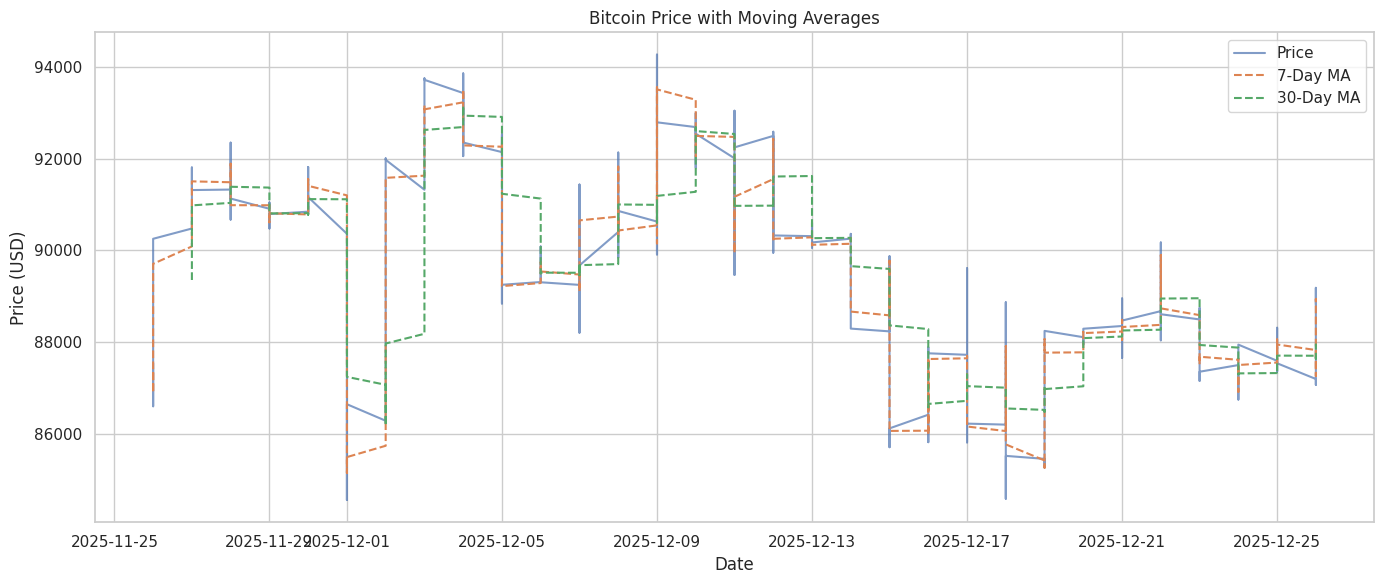

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(merged_df["date"], merged_df["price"], label="Price", alpha=0.7)
plt.plot(merged_df["date"], merged_df["MA_7"], label="7-Day MA", linestyle="--")
plt.plot(merged_df["date"], merged_df["MA_30"], label="30-Day MA", linestyle="--")

plt.title("Bitcoin Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

Volatility Visualization

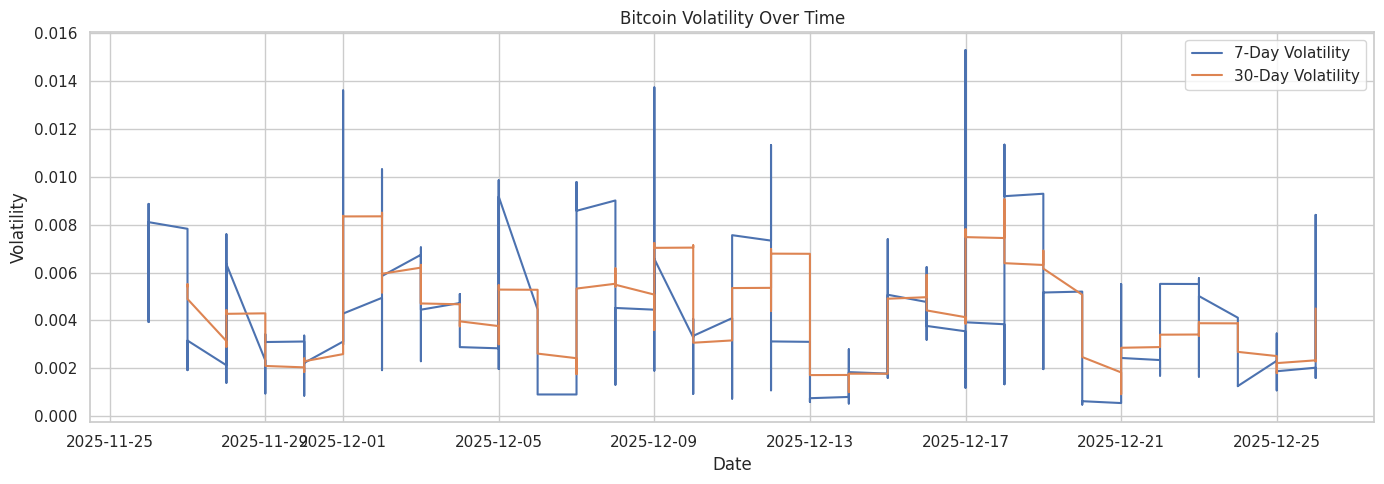

In [38]:
plt.figure(figsize=(14,5))
plt.plot(merged_df["date"], merged_df["volatility_7d"], label="7-Day Volatility")
plt.plot(merged_df["date"], merged_df["volatility_30d"], label="30-Day Volatility")

plt.title("Bitcoin Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
merged_df.to_csv("/content/btc_enriched_dataset.csv", index=False)

### Insight:
Short-term volatility spikes often align with rapid price movements, indicating periods of market uncertainty or heightened trader activity. The 7-day moving average reacts faster to price changes, while the 30-day average highlights longer-term trends. Crossovers between short- and long-term averages can signal potential trend reversals.

##General Insights & Interpretation


- Periods of increased trading volume often align with heightened volatility.
- Short-term volatility reacts faster to market shocks than long-term volatility.
- Moving average crossovers highlight potential trend shifts.
- The data suggests that Bitcoin markets respond rapidly to sentiment-driven activity.


## Conclusion

This analysis demonstrates how on-chain market data can be transformed into meaningful insights using time-series analysis techniques. The findings highlight the importance of volume and volatility in understanding Bitcoin price dynamics and provide a foundation for more advanced crypto analytics.
